# Classification model with Fastai: LSE vowels

**Source:** [Multi-label classification](https://docs.fast.ai/tutorial.vision.html#multi-label-classification)<br>
**Author:** Vanessa Alvear <br>
**Date created:** 2023/05/08<br>
**Last modified:** 2023/05/08<br>
**Description:** Training an image classifier using a pre-trained network for the vowels from the Spanish Sign Language (Lengua de Signos Española - LSE ).

## Introduction

In the next notebook, we are going to create a classification model for 5 hand gestures such as ✌ and 👌, for the vowels of the Spanish Sign Language (Lengua de Signos Española - LSE). To do so, we use the library [fastAI](https://www.fast.ai/). For the data, we create a dataset from scratch. In the next figure, we can see the signs of the vowels from LSE.

We define the GPU to be used

In [1]:
%env CUDA_VISIBLE_DEVICES = 3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
from PIL import Image

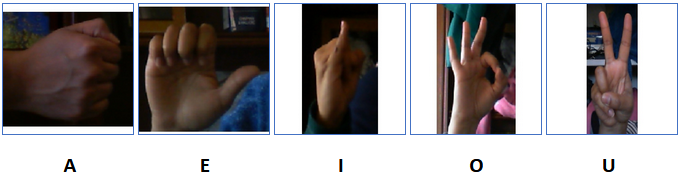

In [3]:
Image.open("vowels-lse-1.png")

## Libraries

We import the necessary libraries 

In [4]:
from fastai.vision.all import *

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import fastai

In [6]:
fastai.__version__

'2.7.12'

In [7]:
#Split dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
import shutil
import random

In [9]:
seed = 1234

## Dataset: vowelsLSE

It was created on May, 2023 in the Universidad de La Rioja. It consists of RGB images of 5 different gestures in JPG format. It contains three folders, one for training `train` (2423 images), one for testing `test` (692 images), one for validation (346 images) for a total of 3461 images. It contains 5 classes. The images can be classified into: 
  - A (332 (right hand) 335 (left hand), total images: 667)
  - E (377 (right hand) 393 (left hand), total images: 770)
  - I (333 (right hand) 335 (left hand), total images: 668)
  - O (340 (right hand) 338 (left hand), total images: 678)
  - U (334 (right hand) 344 (left hand), total images: 678)
  
The images are 400 x 400 in size and have a white background so that they are the same size.

The data is loaded as a folder with .zip extension. Unzip the data

In [10]:
#!unzip vowels_lse_new_data_fastai.zip

The content of this dataset is explored. To do this, a [Path](https://docs.python.org/3/library/pathlib.html) object is created that points to the directory we have just created.

`path` is the folder containing all the folders of the job

In [10]:
full_path = 'vowels_lse_new_data_fastai'
trainPath_st = 'vowels_lse_new_data_fastai/train'
testPath_st = 'vowels_lse_new_data_fastai/test'

In [11]:
path = Path(full_path)

Now we have two folders `train, test` which contains five subfolders, `A, E, I, O`,  and `U`. Each subfolder has image files for each category.

We can create `path` objects that point respectively to the training set and the test set. 

Functions such as ls() can be used with the path object.

In [12]:
trainPath = Path(trainPath_st)
testPath = Path(trainPath_st)

In [26]:
trainPath.ls()

(#5) [Path('vowels_lse_new_data_fastai/train/I'),Path('vowels_lse_new_data_fastai/train/O'),Path('vowels_lse_new_data_fastai/train/U'),Path('vowels_lse_new_data_fastai/train/A'),Path('vowels_lse_new_data_fastai/train/E')]

In [14]:
testPath.ls()

(#5) [Path('vowels_lse_new_data_fastai/test/I'),Path('vowels_lse_new_data_fastai/test/O'),Path('vowels_lse_new_data_fastai/test/U'),Path('vowels_lse_new_data_fastai/test/A'),Path('vowels_lse_new_data_fastai/test/E')]

These are the classes names for the vowels

In [13]:
class_names = ['A', 'E', 'I', 'O', 'U']

Find duplicated images in a folder

In [14]:
def dataframeAllvowels(path_src, classes):
    list1 = []
    for i in classes:
        imagePath = os.path.join(path_src, str(i)+'/')
        list_imagePath = [entry for entry in os.listdir(imagePath) if os.path.isfile(os.path.join(imagePath, entry))]
        df_ = pd.DataFrame(list_imagePath, columns = ['photo_name'])
        list1.append(df_)
        df = pd.concat(list1)
    return df 

In [15]:
df_train = dataframeAllvowels(trainPath_st, class_names)

In [16]:
df_test = dataframeAllvowels(testPath_st, class_names)

In [17]:
frames = [df_train, df_test]
df = pd.concat(frames)

In [18]:
df.duplicated(keep=False).sum()

0

There is no dupplicated data putting all images together.

We can count the number of files in each path

In [33]:
def countFilesPath(path, classNames, path_name):
    for i in classNames:
        print("Number of files "+ path_name + str(i) +" =", len([entry for entry in os.listdir(path+'/'+ str(i)) if os.path.isfile(os.path.join(path+'/'+ str(i), entry))]))

In [34]:
countFilesPath(trainPath_st, class_names, "trainPath_")

Number of files trainPath_A = 534
Number of files trainPath_E = 616
Number of files trainPath_I = 535
Number of files trainPath_O = 542
Number of files trainPath_U = 542


In [35]:
countFilesPath(testPath_st, class_names, "testPath_")

Number of files testPath_A = 133
Number of files testPath_E = 154
Number of files testPath_I = 133
Number of files testPath_O = 136
Number of files testPath_U = 136


We can see that both the `train` folder and the `test` folder contain 5 subfolders, one for each class.

We can see that it contains the *A* folder of the `test` folder.

In [40]:
Path(testPath/'A').ls() 

(#534) [Path('vowels_lse_new_data_fastai/train/A/Image_1683206533.9086118.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273927.5380101.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683208740.7728174.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273848.528547.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683275644.5371656.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273110.9140253.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683209864.4008527.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683208708.3623476.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683274092.720185.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273240.9332352.jpg')...]

In addition, what is contained in the *E* folder of the `test` folder

In [41]:
Path(testPath/'E').ls()

(#616) [Path('vowels_lse_new_data_fastai/train/E/Image_1683285299.0426207.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683287783.9386265.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683288937.6759572.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683285312.6938167.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683285283.8470502.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683289330.0663404.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683287303.163153.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683288964.9881537.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683285184.6568656.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683289325.4711316.jpg')...]

Additional, what is contained in the folder *A* of the folder `train`.

In [42]:
Path(trainPath/'A').ls()

(#534) [Path('vowels_lse_new_data_fastai/train/A/Image_1683206533.9086118.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273927.5380101.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683208740.7728174.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273848.528547.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683275644.5371656.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273110.9140253.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683209864.4008527.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683208708.3623476.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683274092.720185.jpg'),Path('vowels_lse_new_data_fastai/train/A/Image_1683273240.9332352.jpg')...]

and what is contained in the folder *E* of the folder `train`.

In [43]:
Path(trainPath/'E').ls()

(#616) [Path('vowels_lse_new_data_fastai/train/E/Image_1683285299.0426207.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683287783.9386265.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683288937.6759572.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683285312.6938167.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683285283.8470502.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683289330.0663404.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683287303.163153.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683288964.9881537.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683285184.6568656.jpg'),Path('vowels_lse_new_data_fastai/train/E/Image_1683289325.4711316.jpg')...]

We can see that each of the subfolders contains images in jpg format under the above mentioned classes.

## Loading the dataset

The dataset is loaded so that the model can be created later. This process is done in two steps. First a `DataBlock` object is constructed and then a `DataLoader` object is constructed from the `DataBlock`.

### Datablock

To start, the `DataBlock` object is constructed. 

Since there is a training set and a test set, the validation set is randomly taken from the training set using 10% of the training set. In addition, a prescaling technique and a data augmentation technique are applied.

Here, it is important normalize data according to the values from ImageNet. These are the mean, and standard deviation from RGB images.

In [44]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
               get_items=get_image_files, 
               splitter=RandomSplitter(valid_pct=0.1, seed=seed),
               get_y=parent_label,
               item_tfms = Resize(256),
               batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=False,
                  max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)]) 

In the `DataBlock` object we can see that it takes as input value images and the output is the category of each of the images. In the presizing technique is considered by default the method of type ResizeMethod whose default technique is 'crop', this technique takes the images and applies this transformation to randomly crop the images to size 256. Furthermore, in the presizing, the pad_mode of type PadMode is considered whose default value is the 'reflection' technique, this technique reflects the images vertically. 

Additionally, in the data augmentation technique we have the following default transformations are applied:

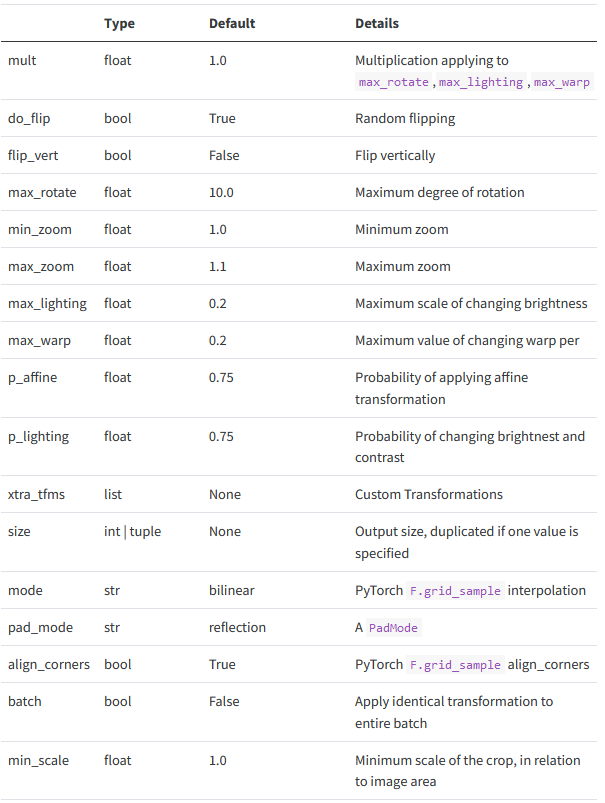

In [46]:
Image.open("transformations_aug_aumentation.png")

In the data enhancement technique we observe that among the transformations applied to the images we can find: rotations, flipping the images in random directions, zooming, warping the images, brightness and [affine transformations](https://en.wikipedia.org/wiki/Affine_transformation) (a geometric transformation that preserves lines and parallelism - but not necessarily distances and angles). 

### Dataloader

Now, the next step is to build the `DataLoader` which is built from the `DataBlock` previously built, indicating the path where the images are located. In addition, we indicate the size of the batch we want to use.

In [20]:
dls = db.dataloaders(trainPath, bs=128) #bs: batch size

A batch of the `DataLoader` is shown below. It is convenient to check that the images and their annotations have really been loaded correctly.

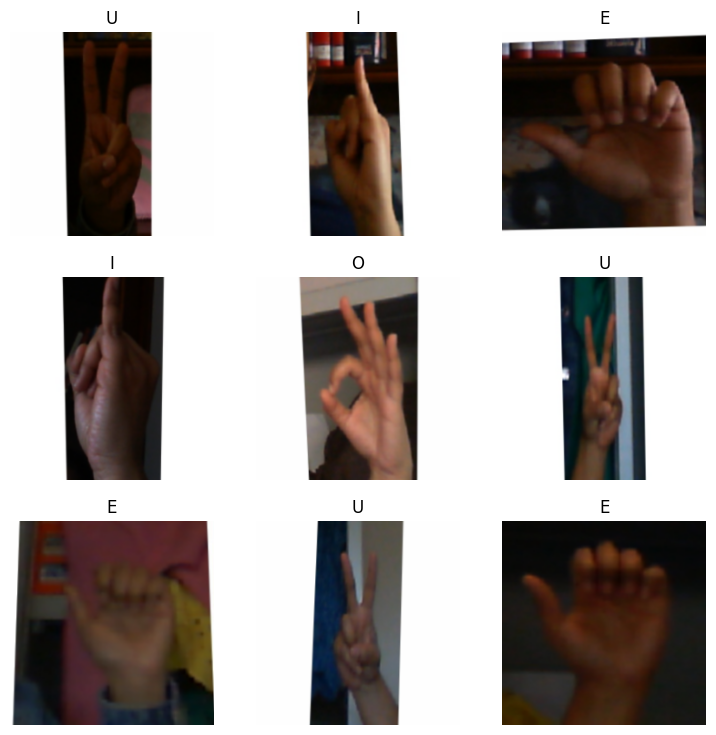

In [21]:
dls.show_batch()

## Training the model 

The next step is to build and train the model. But first, a series of *callbacks* are defined.

We are going to use 3 callbacks:

- ShowGraphCallback. 
- EarlyStoppingCallback. 
- SaveModelCallback. 

With this you want to:

- Show the training and validation curves. 
- It allows to apply the early stopping technique. You must indicate the metric you want to monitor to know when to stop, and the patience (i.e. how many epochs you let the model continue training if there has been no improvement). 
- The best model found during the training process is saved and loaded at the end of the training process.

A model is to be created using the resnet50 architecture and this should be indicated in the model name.

In [22]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3), #Patiente depende del número de épocas
    SaveModelCallback(fname='modelResnet50')  
]

In addition to these three callbacks, another callback will be used to accelerate the training of the models using [*mixed precision*], this callback is indicated differently as shown below.

## Building the model

Next we build the model, an object of the `Learner` class, using the `cnn_learner` method that takes as parameters the `DataLoader`, the architecture to be trained (in this case a `resnet50`), the metric to be used to evaluate our model (this evaluation is done on the validation set, and in our case it will be the *accuracy*), and the callbacks. Note that in the previous instruction we include the transformation of the model to *mixed precision* by means of the instruction ``to_fp16``.

In [23]:
learn = vision_learner(dls, resnet50, metrics=accuracy, cbs=callbacks).to_fp16()

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Note that internally the `vision_learner` function does several things with the architecture that we pass as parameter (in this case `resnet50`). This architecture was initially trained for the ImageNet problem, so when faced with a new image, its output would be the prediction in one of the 1000 ImageNet classes. However, internally the `vision_learner` function removes the last layers of that architecture, and replaces them with one suitable for our particular problem. 

Before training our model we must find a suitable *learning rate*. 

### Learning rate finder

We found with the `lr_find()` function the learning rate.

SuggestedLRs(valley=0.0005754399462603033)

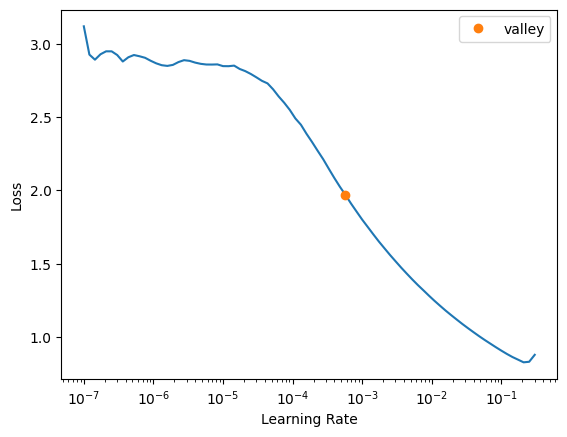

In [51]:
learn.lr_find()

In this case, we are finding the learning rate of the model that we have built, for this, we modify the weights of our network with the objective of learning the model to find the minimum value in which the error has been reduced so that it is not the global minimum (it could not be the global minimum because it would indicate that the model at that value is no longer learning). The value found for the learning rate is 0.001.

### Fine-tuning

Next we are going to apply the technique of *fine tuning*. In FastAI this is as simple as calling the `fine_tune` method of the `Learner` object. This method receives two main parameters, the number of epochs (3 in our case) and the learning rate. The process it follows to train consists of:
1. Freeze all layers except the last one, and train that part of the model for one epoch.
2. Defrost the network, and train the model for the indicated number of epochs. 

We will see a table where you can see the loss for the training set, the loss for the validation set, and the accuracy for the validation set. 

In [24]:
# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

now = 2023-05-08 19:42:59.939752
date and time = 08/05/2023 19:42:59


epoch,train_loss,valid_loss,accuracy,time
0,2.130657,0.734589,0.771739,00:07


Better model found at epoch 0 with valid_loss value: 0.7345888018608093.


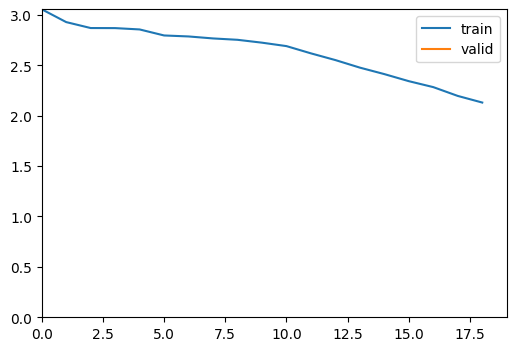

epoch,train_loss,valid_loss,accuracy,time
0,0.800116,0.407977,0.880435,00:07
1,0.676052,0.250318,0.916667,00:07
2,0.531344,0.143111,0.960145,00:07
3,0.402764,0.088821,0.971014,00:07
4,0.302307,0.066953,0.974638,00:07
5,0.231041,0.043635,0.978261,00:07
6,0.176725,0.035766,0.989130,00:07
7,0.134119,0.027904,0.989130,00:07
8,0.107944,0.021266,0.989130,00:07
9,0.084039,0.021125,0.992754,00:07


Better model found at epoch 0 with valid_loss value: 0.40797680616378784.


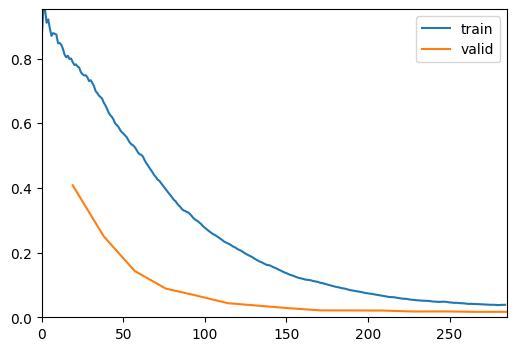

Better model found at epoch 1 with valid_loss value: 0.25031778216362.
Better model found at epoch 2 with valid_loss value: 0.14311105012893677.
Better model found at epoch 3 with valid_loss value: 0.0888209417462349.
Better model found at epoch 4 with valid_loss value: 0.06695293635129929.
Better model found at epoch 5 with valid_loss value: 0.04363461583852768.
Better model found at epoch 6 with valid_loss value: 0.035766396671533585.
Better model found at epoch 7 with valid_loss value: 0.027904115617275238.
Better model found at epoch 8 with valid_loss value: 0.02126562036573887.
Better model found at epoch 9 with valid_loss value: 0.0211249440908432.
Better model found at epoch 10 with valid_loss value: 0.020813068374991417.
Better model found at epoch 11 with valid_loss value: 0.017874082550406456.
Better model found at epoch 13 with valid_loss value: 0.016728777438402176.


In [25]:
learn.fine_tune(15, base_lr=1e-4) 

In [26]:
# datetime object containing current date and time
now1 = datetime.now()
 
print("now =", now1)

# dd/mm/YY H:M:S
dt_string1 = now1.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string1)

now = 2023-05-08 19:45:25.485594
date and time = 08/05/2023 19:45:25


In [56]:
tdelta = now1 - now 

In [57]:
tdelta

datetime.timedelta(seconds=145, microseconds=545842)

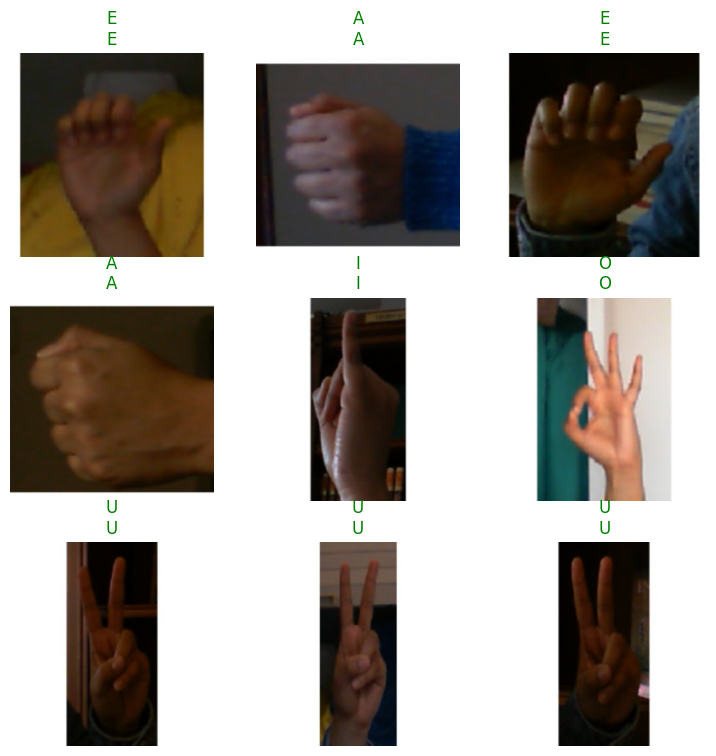

In [27]:
learn.show_results()

At the end of the training a model has been saved in the `models` folder containing the best model built.

In [28]:
Path('models').ls()

(#1) [Path('models/modelResnet50.pth')]

For further use, it is convenient to export the model. To do this, it is first necessary to convert the model to fp32.

In [30]:
learn.to_fp32()
learn.export('export_resnet50.pkl')

We can see that this model has been saved in the same directory where we are. 

In [31]:
Path().ls(file_exts='.pkl')

(#2) [Path('export_resnet50.pkl'),Path('export_resnet.pkl')]

### Evaluation on the validation set

In [32]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9963768124580383.


(#2) [0.01680770330131054,0.9963768124580383]

## Evaluating the model

### Evaluating the model on the test suite

In order to evaluate our model in the test set we must create a new `DataBlock` and a new `DataLoader`. The only difference with the `DataBlock` previously used is that to partition the dataset we use an object of class `GrandparentSplitter` indicating that the validation set is our test set. In the case of the `DataLoader`, the difference with the previously defined is that we change the path to the path. 

In [33]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'), #Usamos el conjunto de test
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=False,
                  max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])

In [34]:
dlsTest = dbTest.dataloaders(path, bs=128)

To work with this dataloader we must modify our `Learner` object. Specifically its `dls` attribute. 

In [35]:
learn.dls = dlsTest

Now we can evaluate our model using the `validate` method.

In [36]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9927745461463928.


(#2) [0.022308267652988434,0.9927745461463928]

The `validate` method returns two values: the value of the loss function, and the value of our metric (the accuracy in this case). So we can see that the model has an accuracy in the test set of approximately 99% (this may vary depending on the execution). 

### Model interpretation

We have seen that our model obtains an approximate accuracy (it may vary due to the randomness of the training process) of 96,9% on the test set. But we are interested in knowing the errors that are made and if they are reasonable. To do this we can construct a `ClassificationInterpretation` object from our `Learner` and display the associated confusion matrix. Remember that we have changed the DataLoader in the previous step, because it is convenient to return to the dataloader used initially.

In [37]:
learn.dls=dls

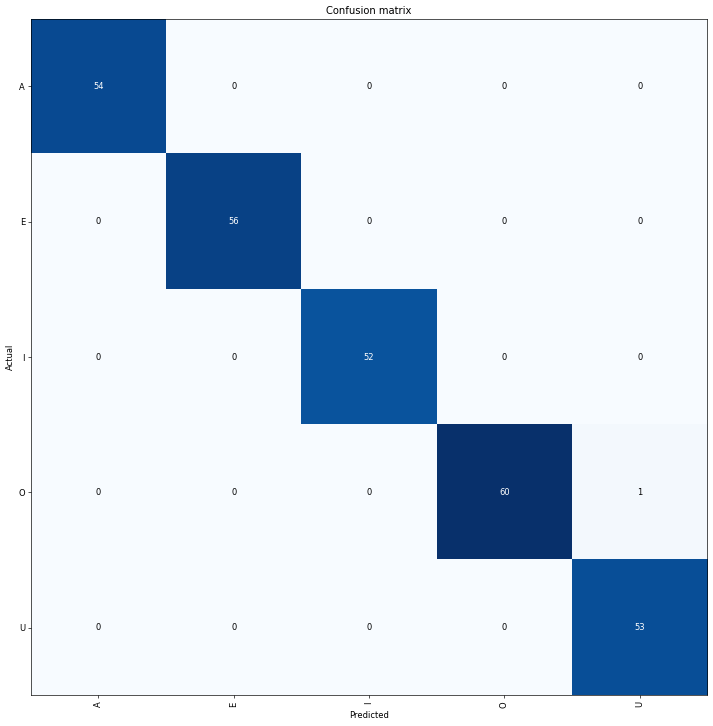

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

We can analyze, the error that happens when the model confuses one image of the `O` class to the `U` class. 

In the following images, we can see samples of the resulting classifications, above the correct classification and, below the prediction.

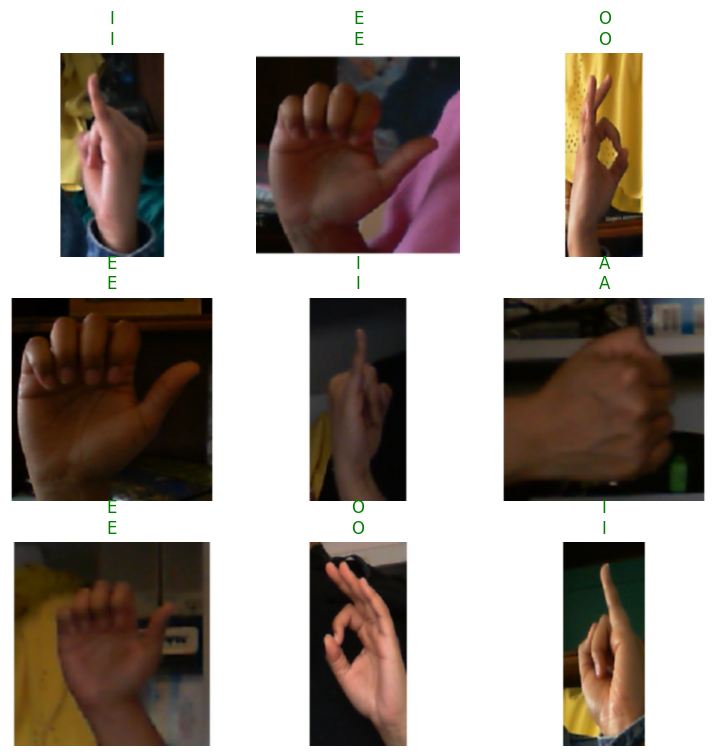

In [39]:
learn.show_results()

In particular, we can see the prediction, actual classification, the values of the loss function and the probability, in the first place the case where was not correct and the others, where is correct.

In [40]:
interp2 = Interpretation.from_learner(learn)

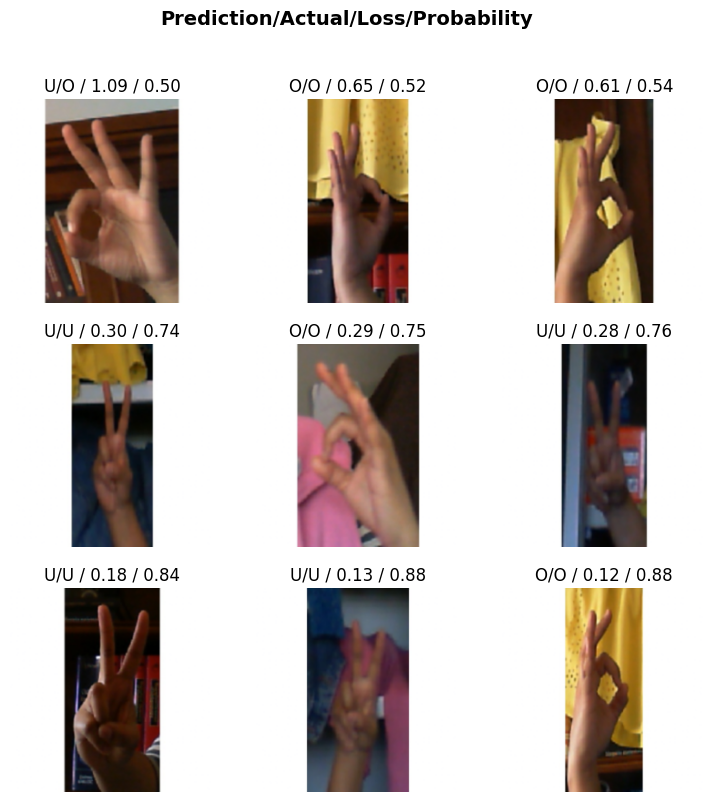

In [41]:
interp2.plot_top_losses(9)

In addition, we applied the test time augmentation technique(tta) to improve model performance

In [42]:
preds,gt=learn.tta()

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(preds,axis=1),gt)

1.0

It improve as much as we expected.

### Using the model

Let's see how to use the model in front of a new image. The first thing we are going to do is to load the model. 

In [44]:
learn_inf = load_learner('export_resnet.pkl')

Using the `predict` method, we can use this model to make inferences with a new image. In our case, we will use an image from the test set. 

In [46]:
learn_inf.predict("otras_imagenes_inferencia/a_otros1.jpg")

('A',
 tensor(0),
 tensor([9.9991e-01, 2.7456e-05, 5.8166e-05, 1.4868e-06, 1.5491e-06]))

The above function returns five values:
- The class (*A* in this case).
- The index associated with that class. 
- The probabilities for each of the categories.  

We can predict on various images 

In [47]:
def prediction(image_list):
    return [learn_inf.predict(i) for i in image_list]

New images with the same person which build the dataset

In [50]:
# These are the images with size (1280,720)
other_image_list = ["otras_imagenes_inferencia/a_otros1.jpg", "otras_imagenes_inferencia/e_otros1.jpg", "otras_imagenes_inferencia/i_otros1.jpg", "otras_imagenes_inferencia/o_otros1.jpg", "otras_imagenes_inferencia/u_otros1.jpg"]

In [51]:
prediction(big_image_list)

[('A',
  tensor(0),
  tensor([9.9991e-01, 2.7456e-05, 5.8166e-05, 1.4868e-06, 1.5491e-06])),
 ('E',
  tensor(1),
  tensor([2.5858e-03, 9.8723e-01, 8.6809e-03, 4.7978e-04, 1.0193e-03])),
 ('I',
  tensor(2),
  tensor([1.2676e-04, 8.9785e-06, 9.9616e-01, 1.8256e-03, 1.8741e-03])),
 ('O',
  tensor(3),
  tensor([9.3444e-08, 3.0267e-07, 1.0181e-06, 9.9999e-01, 3.5374e-06])),
 ('U',
  tensor(4),
  tensor([3.0454e-03, 5.1079e-05, 1.1656e-02, 2.3052e-01, 7.5472e-01]))]

Test images

In [52]:
# These are the images from test set with size (300, 300)
test_image_list = ["a_test.jpg", "e_test.jpg", "i_test.jpg", "o_test.jpg", "u_test.jpg"]

In [53]:
prediction(test_image_list)

[('A',
  tensor(0),
  tensor([9.9938e-01, 5.5223e-04, 1.6193e-05, 2.8768e-05, 1.8887e-05])),
 ('E',
  tensor(1),
  tensor([1.2381e-06, 9.9997e-01, 1.9985e-05, 1.1102e-05, 3.3172e-07])),
 ('I',
  tensor(2),
  tensor([1.4549e-05, 8.4833e-06, 9.9937e-01, 5.4764e-04, 6.1126e-05])),
 ('O',
  tensor(3),
  tensor([3.9622e-03, 2.0006e-03, 8.0698e-05, 9.9340e-01, 5.5928e-04])),
 ('U',
  tensor(4),
  tensor([1.4698e-04, 1.8548e-05, 4.0611e-02, 8.1172e-04, 9.5841e-01]))]

We can notice, using the model for different images that the model not seen before, with diffierent sizes, the classification works classifying correctly the images.

Some additional references that allowed this work to be carried out

1. Affine transformations: https://en.wikipedia.org/wiki/Affine_transformation

2. Presizing and aug_aumentation: https://docs.fast.ai/vision.augment#aug_transforms